In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astropy
import gammapy
print(gammapy.__version__)
print(np.__version__)

from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs
gammapy.data.HDUIndexTable.VALID_HDU_CLASS

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    GaussianSpatialModel,
    PointSpatialModel,
    FoVBackgroundModel,
    Models
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region

0.18.2
1.19.4


In [10]:
data_store = DataStore.from_dir("/Users/cedrickperron/GAMMAPY/LS5039_new")
s = data_store.hdu_table.read("/Users/cedrickperron/GAMMAPY/LS5039_new/hdu-index.fits.gz")
OBS_table = data_store.obs_table.read("/Users/cedrickperron/GAMMAPY/LS5039_new/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
s.remove_column("FILE_DIR")
s.add_column("/Users/cedrickperron/GAMMAPY/LS5039_new", name="FILE_DIR")



In [11]:
data_store.hdu_table = s
hdu_table = data_store.hdu_table
data_store.obs_table
print(data_store.hdu_table)

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]

#print(obs_id)

# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)



No HDU found matching: OBS_ID = 69123, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69187, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69188, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69202, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 69203, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73193, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73213, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73234, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73300, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73317, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73335, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73356, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73357, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 73370, HDU_TYPE = bkg, HDU_CLASS

OBS_ID HDU_TYPE ...      HDU_NAME                     FILE_DIR               
------ -------- ... ----------------- ---------------------------------------
 69123   events ...            EVENTS /Users/cedrickperron/GAMMAPY/LS5039_new
 69123      gti ...               GTI /Users/cedrickperron/GAMMAPY/LS5039_new
 69123     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/LS5039_new
 69123    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/LS5039_new
 69123      psf ...               PSF /Users/cedrickperron/GAMMAPY/LS5039_new
 69187   events ...            EVENTS /Users/cedrickperron/GAMMAPY/LS5039_new
 69187      gti ...               GTI /Users/cedrickperron/GAMMAPY/LS5039_new
 69187     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/LS5039_new
 69187    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/LS5039_new
 69187      psf ...               PSF /Users/cedrickperron/GAMMAPY/LS5039_new
   ...      ... ...               ...                           

In [12]:
target_position = SkyCoord(ra="18h26m15s",dec="-14d49m30s", frame="icrs")
#help(SkyCoord)
print(target_position)
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

<SkyCoord (ICRS): (ra, dec) in deg
    (276.5625, -14.825)>


In [13]:
# The binning of the final spectrum is defined here.
energy_axis = MapAxis.from_energy_bounds(0.1, 40.0, 10, unit="TeV", name="energy")

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 30, unit="TeV", name="energy_true"
)

# Here we use 1.5 degree which is slightly larger than needed.
geom = WcsGeom.create(skydir=target_position, binsz=0.01, width=(5,5), proj="CAR",axes=[energy_axis])

geom_image = geom.to_image()

# LS5039 Region
center1 = SkyCoord("276.562 deg","-14.825 deg", frame="icrs")
LS5039_region = CircleSkyRegion(center=center1, radius=0.25* u.deg)


center_region = CircleSkyRegion(center=target_position, radius=0.25* u.deg)

exclusion_mask=Map.from_geom(geom_image)
exclusion_mask.data=geom_image.region_mask([center_region, LS5039_region], inside=False)
# No pixel => Energy => 0 (no signal)
#exclusion_mask.sum_over_axes().plot(add_cbar=True)

CANNOT ADD THE "edisp" part, because of issue

In [14]:
maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf"])

#maker = MapDatasetMaker(selection=["counts", "exposure", "psf"])

In [15]:

#Create an empty 1D SpectrumDataset: Note here we don't have a background model, thus we can only define a SpectrumDataset background
e_reco = energy_axis
e_true = energy_axis_true
#Create an empty dataset that you will use for each observation
dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)

# Create the DatasetMaker
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "psf", "edisp"])
# Create the Background Maker
#help(ReflectedRegionsBackgroundMaker)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
#Create a Safe_mask_maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=2.5*u.deg)


# Create a stacked dataset
#stacked = SpectrumDatasetOnOff.create(e_reco=e_reco,  e_true=e_true, region=on_region)
#help(dataset.to_spectrum_dataset)


In [16]:
%%time
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="HESS J1826-148"
)

empty_dataset = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="HESS J1826-148"
)

datasets = Datasets()

for obs in observations:
    # A MapDataset is filled in this geometry
    dataset = maker.run(empty_dataset.copy(name=f"{obs.obs_id}"), obs)
    # To make images, the resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

    # Extract 1D spectrum
    spectrum_dataset = dataset.to_spectrum_dataset(
        on_region, containment_correction= True, name=f"obs-{obs.obs_id}"
    )
    # Compute OFF
    spectrum_dataset = bkg_maker.run(spectrum_dataset, obs)
    # Define safe mask
    spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)
    # Append dataset to the list
    datasets.append(spectrum_dataset)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate

CPU times: user 59.2 s, sys: 17.6 s, total: 1min 16s
Wall time: 1min 25s


In [17]:
datasets.meta_table

NAME,TYPE,TELESCOP,OBS_ID,RA_PNT,DEC_PNT
,,,,deg,deg
str9,str20,str7,int64,float64,float64
obs-69123,SpectrumDatasetOnOff,VERITAS,69123,276.4937438964844,-15.29050350189209
obs-69187,SpectrumDatasetOnOff,VERITAS,69187,276.96624755859375,-14.778938293457031
obs-69188,SpectrumDatasetOnOff,VERITAS,69188,276.01361083984375,-14.766154289245605
obs-69202,SpectrumDatasetOnOff,VERITAS,69202,276.4831848144531,-14.290704727172852
obs-69203,SpectrumDatasetOnOff,VERITAS,69203,276.4649963378906,-15.287714004516602
obs-73193,SpectrumDatasetOnOff,VERITAS,73193,276.0265808105469,-14.808158874511719
obs-73213,SpectrumDatasetOnOff,VERITAS,73213,276.5266418457031,-14.309259414672852
obs-73234,SpectrumDatasetOnOff,VERITAS,73234,276.52069091796875,-15.287755966186523


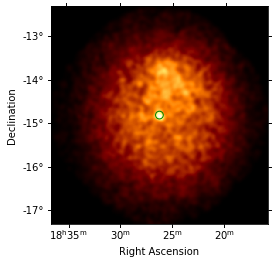

In [18]:
stacked.counts.sum_over_axes().smooth(width="0.05 deg").plot()
on_region.to_pixel(stacked.counts.geom.wcs).plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fab1cf75128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fab1d4d7c50>)

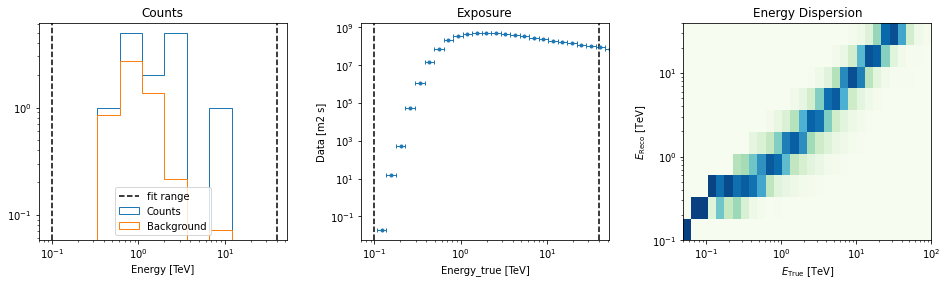

In [19]:
datasets[0].peek()

In [20]:
info_table = datasets.info_table(cumulative=True)

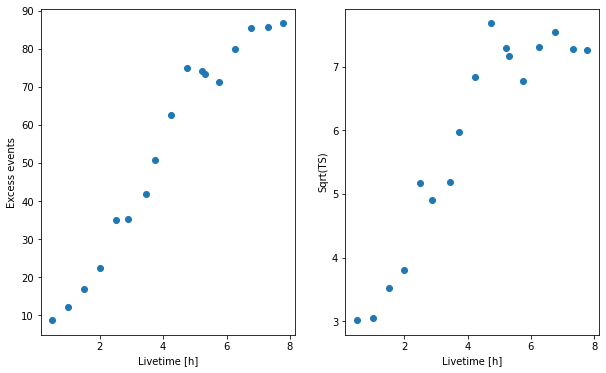

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121)
ax.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess events")

ax = fig.add_subplot(122)
ax.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

In [22]:
spectral_model = PowerLawSpectralModel(
    index=2.50, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
sky_model = SkyModel(spectral_model=spectral_model, name="HESS J1826-148")

#datasets.models = Models([sky_model])

for dataset in datasets:
    dataset.model = sky_model

In [23]:
%%time
fit_joint = Fit(datasets[0])
result_joint = fit_joint.run()
print(result_joint)

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:
result_joint.parameters.to_table()

NameError: name 'result_joint' is not defined

In [ ]:
# First stack them all
reduced = datasets.stack_reduce()
# Assign the fitted model
reduced.models = model
# Plot the result
reduced.plot_fit();